# Deep Learning
## Dogs vs Cats

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from PIL import Image
import tensorflow as tf
import shutil

In [74]:
training_images = "../lab_2/original_data/train/train"
test_images = "../lab_2/original_data/test/test"

train_size = len([name for name in os.listdir(training_images)])
test_size = len([name for name in os.listdir(test_images)])

print("Number of training images: ", train_size)
print("Number of testing images: ", test_size)

Number of training images:  19991
Number of testing images:  12487


0. EDA och filhantering (*)
- a) Börja med att ladda ned datasetet Dogs vs Cats från Kaggle. Extrahera den och lägg den i din labfolder, glöm inte att lägga till den till .gitignore.
- b) Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln


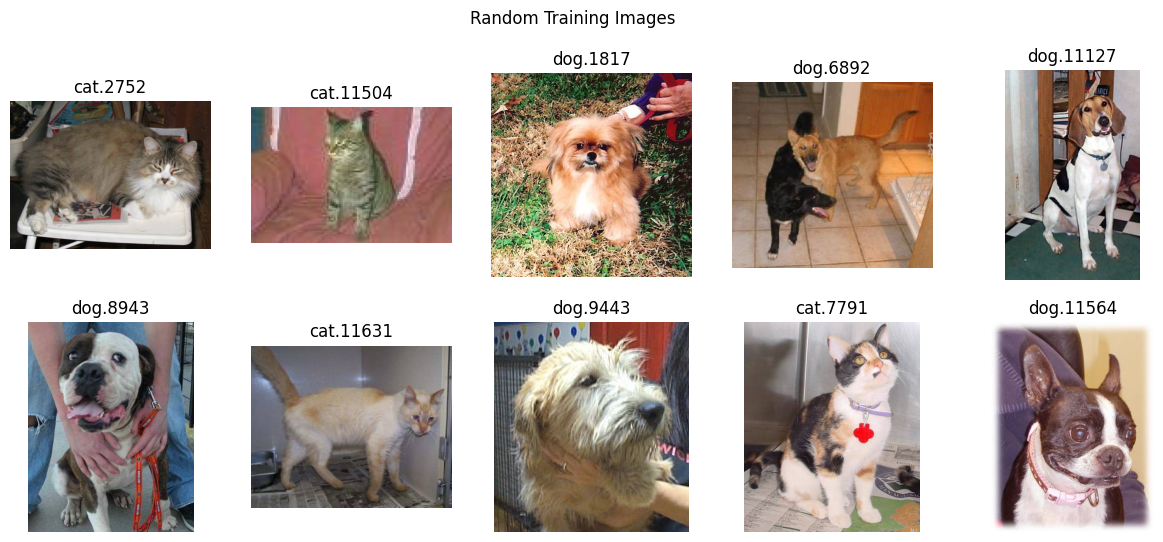

In [75]:
# list of all image filenames in the training folder
image_files = os.listdir(training_images)

# Select 10 random images
random_images = random.sample(image_files, 10)

# Plot 
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Random Training Images')

for i, image_file in enumerate(random_images):
    image_path = os.path.join(training_images, image_file)
    image = Image.open(image_path)
    
    label = '.'.join(image_file.split('.')[:2])  # Split after the second "."
    
    # Plot the image
    ax = axes[i // 5, i % 5]
    ax.imshow(image)
    ax.set_title(label)
    ax.axis('off')

plt.show()

c) Skapa folderstrukturen nedan med Python:

```
.
├── experiment_small_data
│   ├── test
│   ├── train
│   └── val
├── experiment_tiny_data
│   ├── test
│   ├── train
│   └── val
├── lab.ipynb
└── original_data
 ├── test
 │   └── test
 └── train
 └── train

```

In [76]:
# current directory
base_dir = os.getcwd()

# Define main experiment folders
experiments = ["experiment_small_data", "experiment_tiny_data"]

# Define subfolders
subfolders = ["test", "train", "val"]

# Create folders
for experiment in experiments:
  experiment_path = os.path.join(base_dir, experiment)
  if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)  # Create experiment directory

  # Create subfolders within each experiment
  for subfolder in subfolders:
    subfolder_path = os.path.join(experiment_path, subfolder)
    if not os.path.exists(subfolder_path):
      os.makedirs(subfolder_path)

d) Nu ska du göra train|val|test split med följande splits:

experiment_small

    train - 1600 (800 dogs, 800 cats)
    val - 400 (200 dogs, 200 cats)
    test - 500 (250 dogs, 250 cats)

In [77]:
experiment_path = "experiment_small_data"

# Function to move images to each respective subfolder based on target numbers
def move_images_to_subfolders():
    # Define the target numbers of images per subfolder
    target_counts = {
        "train": {"dog": 800, "cat": 800},
        "val": {"dog": 200, "cat": 200},
        "test": {"dog": 250, "cat": 250}
    }
    
    # Iterate over each subfolder and move images
    for subfolder, label_counts in target_counts.items():
        # Get list of images to move
        images_to_move = [f for f in os.listdir(training_images)]
        # Shuffle the list of images for randomness
        random.shuffle(images_to_move)
        
        # Move the correct number of images containing "cat" and "dog" to the subfolder
        for label, count in label_counts.items():
            # Filter images containing the current label
            label_images = [image for image in images_to_move if label in image]
            # Move the specified number of images for the label
            for image in label_images[:count]:
                src = os.path.join(training_images, image)
                dest = os.path.join(experiment_path, subfolder, image)
                shutil.move(src, dest)

# Call the function to move images to each respective subfolder ("commented" to avoid multiple additions)
#move_images_to_subfolders()


#### checking if the count is right

In [78]:
for subfolder in subfolders:
    subfolder_path = os.path.join(experiment_path, subfolder)
    dogs_count = len([name for name in os.listdir(subfolder_path) if "dog" in name])
    cats_count = len([name for name in os.listdir(subfolder_path) if "cat" in name])
    print(f"Subfolder: {subfolder}")
    print(f"Number of dogs: {dogs_count}")
    print(f"Number of cats: {cats_count}")
    print()


Subfolder: test
Number of dogs: 250
Number of cats: 250

Subfolder: train
Number of dogs: 800
Number of cats: 800

Subfolder: val
Number of dogs: 200
Number of cats: 200



e) Läs in dataseten från experiment_small, experiment_tiny (BONUS) och plocka ut labelsvektorer, som ska vara one-hot encoded med 0 och 1.

- plotta några bilder med deras respektive labels och kontrollera att det är korrekt.
- skapa lämplig plot för att kontrollera att dataseten är balanserade
- skapa lämplig plot för att kontrollera att dataseten är slumpade, dvs inte ex [0, 0, ... 0, 1, 1, ..., 1]

In [96]:
datapath = Path().absolute().parent / "lab_2/experiment_small_data" / "train"

train_filenames = [str(path) for path in train_datapath.glob("*.jpg")]

random.shuffle(train_filenames)

len(train_filenames)

1600

In [98]:
train_filenames[:5]

['c:\\Users\\arthu\\Documents\\repos\\VS\\OPA - Semester 2\\Python\\AI2-Arthur-Lopez-OPA23\\lab_2\\experiment_small_data\\train\\cat.3497.jpg',
 'c:\\Users\\arthu\\Documents\\repos\\VS\\OPA - Semester 2\\Python\\AI2-Arthur-Lopez-OPA23\\lab_2\\experiment_small_data\\train\\cat.3544.jpg',
 'c:\\Users\\arthu\\Documents\\repos\\VS\\OPA - Semester 2\\Python\\AI2-Arthur-Lopez-OPA23\\lab_2\\experiment_small_data\\train\\cat.7984.jpg',
 'c:\\Users\\arthu\\Documents\\repos\\VS\\OPA - Semester 2\\Python\\AI2-Arthur-Lopez-OPA23\\lab_2\\experiment_small_data\\train\\dog.7861.jpg',
 'c:\\Users\\arthu\\Documents\\repos\\VS\\OPA - Semester 2\\Python\\AI2-Arthur-Lopez-OPA23\\lab_2\\experiment_small_data\\train\\dog.7859.jpg']

In [101]:
def load_images_and_labels(train_filenames, target_size=(150, 150)):
    images = []
    labels = []
    
    for filename in train_filenames:
        image = Image.open(filename)
        # Resize image to a fixed size
        image = image.resize(target_size)
        # Image -> Numpy Array conversion
        image_array = np.array(image) / 255.0
        # Append the image array to the list of images
        images.append(image_array)
        
        # Extract the label 
        label = 1 if "dog" in filename else 0
        # Append label 
        labels.append(label)
    
    # Convert the lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

train_images, train_labels = load_images_and_labels(train_filenames)

train_images.shape

(1600, 150, 150, 3)

In [104]:
train_labels

array([0, 0, 0, ..., 1, 0, 0])

In [110]:
"dog" in train_filenames[1]

False

Plotting some train images

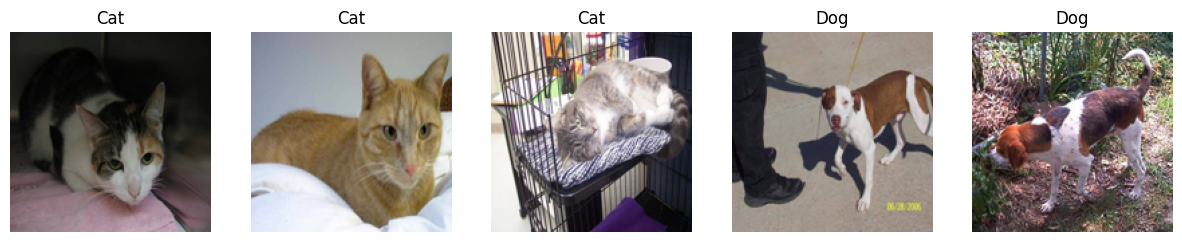

In [111]:
def plot_images(images, labels, num_images=5):
    # Randomly select num_images
    indices = np.random.choice(len(images), size=num_images, replace=False)
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, idx in enumerate(indices):
        axes[i].imshow(images[idx])
        axes[i].set_title("Dog" if labels[idx] == 1 else "Cat")
        axes[i].axis('off')
    plt.show()

plot_images(train_images, train_labels)

Distribution of classes 

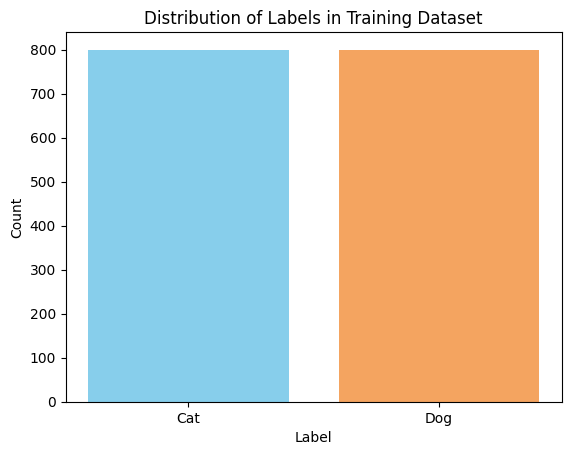

In [115]:
def plot_label_distribution(labels):
    # Count the occurrences of each label
    label_counts = np.bincount(labels)
    
    plt.bar(["Cat", "Dog"], label_counts, color=['skyblue', 'sandybrown'])
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of Labels in Training Dataset')
    plt.show()

plot_label_distribution(train_labels)


Randomization check

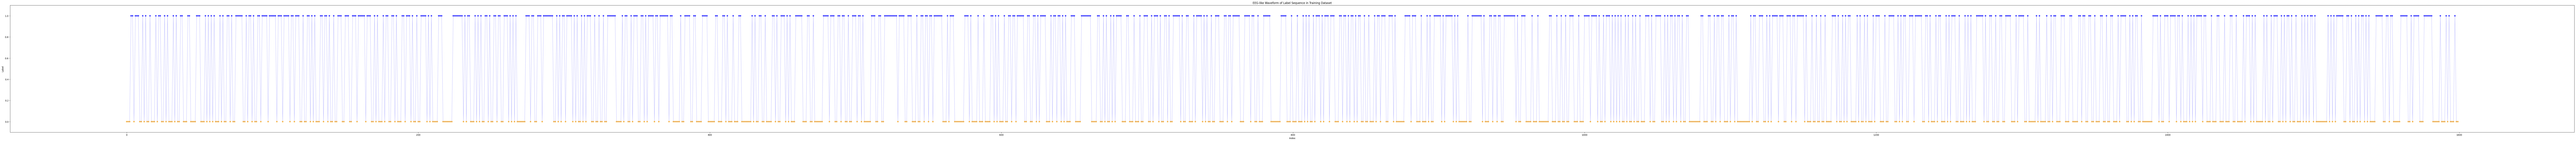

In [144]:
import seaborn as sns

# Define a function to plot the EEG-like waveform of label sequence using Seaborn
def plot_label_waveform(labels):
    # Create an array of indices corresponding to the label sequence
    indices = np.arange(len(labels))
    
    # Create a DataFrame with indices and labels
    data = pd.DataFrame({'Index': indices, 'Label': labels})
    
    # Set figure size
    plt.figure(figsize=(200, 10))
    
    # Plot the EEG-like waveform of label sequence using Seaborn
    sns.lineplot(data=data, x='Index', y='Label', color='blue', linewidth=1, alpha=0.3)  # Plot the line with transparency
    sns.scatterplot(data=data, x='Index', y='Label', hue='Label', palette={0: 'orange', 1: 'blue'}, s=50, legend=False, alpha=0.7)  # Increase markers' size and add transparency
    
    plt.xlabel('Index')
    plt.ylabel('Label')
    plt.title('EEG-like Waveform of Label Sequence in Training Dataset')
    plt.ylim(-0.1, 1.1)  # Set y-axis limits to include the full range of labels
    plt.show()

# Plot the EEG-like waveform of label sequence in the training dataset using Seaborn
plot_label_waveform(train_labels)


